# Company Clustering Analysis - Multi-Method Approach

This notebook performs comprehensive clustering analysis on company aggregated statistics to classify suppliers into 3 performance tiers:
- **Low Performance**: Companies needing significant improvement
- **Mid Performance**: Companies with balanced performance
- **High Performance**: Top-tier companies

**Methods Applied:**
1. K-Means Clustering
2. DBSCAN Clustering
3. Hierarchical Clustering
4. Ensemble Clustering (Consensus of all three)

**Evaluation Metrics:**
- Silhouette Score (higher is better)
- Davies-Bouldin Score (lower is better)
- Calinski-Harabasz Score (higher is better)

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
TARGET_CLUSTERS = 3  # Low, Mid, High performance tiers
RANDOM_STATE = 42

print("Libraries imported successfully!")
print(f"Target clusters: {TARGET_CLUSTERS} (Low, Mid, High)")

Libraries imported successfully!
Target clusters: 3 (Low, Mid, High)


In [3]:
# Load and Explore Company Data
def load_company_data():
    """
    Load the aggregated company statistics data.
    """
    print("Loading company aggregated statistics...\n")
    
    df = pd.read_csv('../data/raw/supplier_aggregated_stats.csv')
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of companies: {len(df)}")
    print(f"Number of features: {len(df.columns) - 1}\n")  # Excluding supplier_id
    
    print("Available features:")
    for i, col in enumerate(df.columns[1:], 1):
        print(f"  {i:2d}. {col}")
    
    print("\nData preview:")
    print(df.head())
    
    print("\nBasic statistics:")
    print(df.describe())
    
    return df

df_raw = load_company_data()

Loading company aggregated statistics...

Dataset shape: (25, 17)
Number of companies: 25
Number of features: 16

Available features:
   1. delivery_reliability_mean
   2. delivery_reliability_std
   3. delivery_reliability_min
   4. delivery_reliability_max
   5. cost_efficiency_mean
   6. cost_efficiency_std
   7. defect_rate_mean
   8. defect_rate_std
   9. quality_score_mean
  10. quality_score_std
  11. customer_satisfaction_mean
  12. customer_satisfaction_std
  13. order_volume_sum
  14. order_volume_mean
  15. overall_score_mean
  16. overall_score_std

Data preview:
  supplier_id  delivery_reliability_mean  delivery_reliability_std  \
0     SUP_001                      74.87                      5.61   
1     SUP_002                      39.72                      1.33   
2     SUP_003                      61.50                      3.38   
3     SUP_004                      66.22                      5.22   
4     SUP_005                      77.98                      3.66  

In [4]:
# Prepare Features for Clustering
def prepare_clustering_features(df):
    """
    Select and scale features for clustering.
    Focus on mean values and key performance indicators.
    """
    print("Preparing features for clustering...\n")
    
    # Select key performance features (mean values and aggregates)
    feature_columns = [
        'delivery_reliability_mean',
        'cost_efficiency_mean',
        'defect_rate_mean',
        'quality_score_mean',
        'customer_satisfaction_mean',
        'overall_score_mean',
        'order_volume_mean'
    ]
    
    print("Selected clustering features:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"  {i}. {feature}")
    
    # Extract features
    X = df[feature_columns].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"\nFeature matrix shape: {X_scaled.shape}")
    print(f"Scaled data - Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")
    
    return X_scaled, feature_columns, scaler

X_scaled, feature_columns, scaler = prepare_clustering_features(df_raw)

Preparing features for clustering...

Selected clustering features:
  1. delivery_reliability_mean
  2. cost_efficiency_mean
  3. defect_rate_mean
  4. quality_score_mean
  5. customer_satisfaction_mean
  6. overall_score_mean
  7. order_volume_mean

Feature matrix shape: (25, 7)
Scaled data - Mean: 0.0000, Std: 1.0000


In [5]:
# Common Evaluation Function
def evaluate_clustering(X, labels, method_name):
    """
    Evaluate clustering quality using multiple metrics.
    """
    # Filter out noise points for DBSCAN
    valid_mask = labels >= 0
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    if len(np.unique(labels_valid)) < 2:
        print(f"\n{method_name} - Insufficient clusters for evaluation")
        return None
    
    sil_score = silhouette_score(X_valid, labels_valid)
    db_score = davies_bouldin_score(X_valid, labels_valid)
    ch_score = calinski_harabasz_score(X_valid, labels_valid)
    
    print(f"\n{method_name} - Clustering Quality Metrics:")
    print(f"  Silhouette Score:       {sil_score:7.4f} (higher is better)")
    print(f"  Davies-Bouldin Score:   {db_score:7.4f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {ch_score:7.2f} (higher is better)")
    
    return {
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }

print("Evaluation function ready")

Evaluation function ready


---
## Method 1: K-Means Clustering

K-Means is a centroid-based algorithm that partitions data into k clusters by minimizing within-cluster variance.

In [6]:
# K-Means Clustering
def apply_kmeans_clustering(X, n_clusters=TARGET_CLUSTERS):
    """
    Apply K-Means clustering with specified number of clusters.
    """
    print(f"\n{'='*70}")
    print("K-MEANS CLUSTERING")
    print(f"{'='*70}\n")
    
    print(f"Applying K-Means with {n_clusters} clusters...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\nCluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"  Cluster {cluster_id}: {count:2d} companies ({percentage:5.1f}%)")
    
    # Evaluate
    metrics = evaluate_clustering(X, labels, "K-Means")
    
    return labels, kmeans, metrics

kmeans_labels, kmeans_model, kmeans_metrics = apply_kmeans_clustering(X_scaled)

# Add to dataframe
df_kmeans = df_raw.copy()
df_kmeans['cluster'] = kmeans_labels
print(f"\nK-Means clustering complete")


K-MEANS CLUSTERING

Applying K-Means with 3 clusters...

Cluster Distribution:
  Cluster 0: 12 companies ( 48.0%)
  Cluster 1:  3 companies ( 12.0%)
  Cluster 2: 10 companies ( 40.0%)

K-Means - Clustering Quality Metrics:
  Silhouette Score:        0.2684 (higher is better)
  Davies-Bouldin Score:    1.2683 (lower is better)
  Calinski-Harabasz Score:    9.65 (higher is better)

K-Means clustering complete

Cluster Distribution:
  Cluster 0: 12 companies ( 48.0%)
  Cluster 1:  3 companies ( 12.0%)
  Cluster 2: 10 companies ( 40.0%)

K-Means - Clustering Quality Metrics:
  Silhouette Score:        0.2684 (higher is better)
  Davies-Bouldin Score:    1.2683 (lower is better)
  Calinski-Harabasz Score:    9.65 (higher is better)

K-Means clustering complete


---
## Method 2: DBSCAN Clustering

DBSCAN is a density-based algorithm that can identify clusters of arbitrary shape and detect outliers.

In [7]:
# DBSCAN Clustering
def apply_dbscan_clustering(X):
    """
    Apply DBSCAN clustering with optimized parameters for 3 clusters.
    """
    print(f"\n{'='*70}")
    print("DBSCAN CLUSTERING")
    print(f"{'='*70}\n")
    
    print("Searching for optimal DBSCAN parameters...")
    
    best_params = None
    best_score = -1
    best_labels = None
    
    # Grid search for parameters that give 3 clusters
    eps_values = np.arange(0.5, 3.0, 0.1)
    min_samples_values = [2, 3, 4, 5]
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Look for 3 clusters with minimal noise
            if n_clusters == TARGET_CLUSTERS and n_noise < len(X) * 0.2:  # Less than 20% noise
                valid_mask = labels >= 0
                if valid_mask.sum() > TARGET_CLUSTERS:  # Ensure enough points
                    sil_score = silhouette_score(X[valid_mask], labels[valid_mask])
                    if sil_score > best_score:
                        best_score = sil_score
                        best_params = {'eps': eps, 'min_samples': min_samples}
                        best_labels = labels
    
    if best_params is None:
        print("No optimal parameters found for 3 clusters, using fallback...")
        dbscan = DBSCAN(eps=1.5, min_samples=2)
        best_labels = dbscan.fit_predict(X)
        best_params = {'eps': 1.5, 'min_samples': 2}
    
    print(f"\nOptimal Parameters:")
    print(f"  eps: {best_params['eps']:.2f}")
    print(f"  min_samples: {best_params['min_samples']}")
    
    # Cluster distribution
    n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
    n_noise = list(best_labels).count(-1)
    
    print(f"\nClusters found: {n_clusters}")
    print(f"Noise points: {n_noise}\n")
    
    print("Cluster Distribution:")
    unique, counts = np.unique(best_labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(best_labels)) * 100
        label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
        print(f"  {label}: {count:2d} companies ({percentage:5.1f}%)")
    
    # Evaluate
    metrics = evaluate_clustering(X, best_labels, "DBSCAN")
    
    return best_labels, best_params, metrics

dbscan_labels, dbscan_params, dbscan_metrics = apply_dbscan_clustering(X_scaled)

# Add to dataframe
df_dbscan = df_raw.copy()
df_dbscan['cluster'] = dbscan_labels
print(f"\nDBSCAN clustering complete")


DBSCAN CLUSTERING

Searching for optimal DBSCAN parameters...
No optimal parameters found for 3 clusters, using fallback...

Optimal Parameters:
  eps: 1.50
  min_samples: 2

Clusters found: 4
Noise points: 8

Cluster Distribution:
  Noise:  8 companies ( 32.0%)
  Cluster 0:  5 companies ( 20.0%)
  Cluster 1:  3 companies ( 12.0%)
  Cluster 2:  6 companies ( 24.0%)
  Cluster 3:  3 companies ( 12.0%)

DBSCAN - Clustering Quality Metrics:
  Silhouette Score:        0.3667 (higher is better)
  Davies-Bouldin Score:    0.8191 (lower is better)
  Calinski-Harabasz Score:   12.52 (higher is better)

DBSCAN clustering complete


---
## Method 3: Hierarchical Clustering

Hierarchical clustering builds a tree of clusters using agglomerative (bottom-up) approach.

In [8]:
# Hierarchical Clustering
def apply_hierarchical_clustering(X, n_clusters=TARGET_CLUSTERS):
    """
    Apply Hierarchical clustering with optimal linkage method.
    """
    print(f"\n{'='*70}")
    print("HIERARCHICAL CLUSTERING")
    print(f"{'='*70}\n")
    
    print(f"Testing different linkage methods for {n_clusters} clusters...\n")
    
    linkage_methods = ['ward', 'complete', 'average', 'single']
    best_linkage = None
    best_score = -1
    best_labels = None
    
    for linkage_method in linkage_methods:
        clusterer = AgglomerativeClustering(
            n_clusters=n_clusters,
            metric='euclidean',
            linkage=linkage_method
        )
        labels = clusterer.fit_predict(X)
        
        sil_score = silhouette_score(X, labels)
        print(f"  {linkage_method:10s}: Silhouette = {sil_score:.4f}")
        
        if sil_score > best_score:
            best_score = sil_score
            best_linkage = linkage_method
            best_labels = labels
    
    print(f"\nBest linkage method: {best_linkage}")
    
    # Cluster distribution
    unique, counts = np.unique(best_labels, return_counts=True)
    print("\nCluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(best_labels)) * 100
        print(f"  Cluster {cluster_id}: {count:2d} companies ({percentage:5.1f}%)")
    
    # Evaluate
    metrics = evaluate_clustering(X, best_labels, "Hierarchical")
    
    return best_labels, best_linkage, metrics

hierarchical_labels, hierarchical_linkage, hierarchical_metrics = apply_hierarchical_clustering(X_scaled)

# Add to dataframe
df_hierarchical = df_raw.copy()
df_hierarchical['cluster'] = hierarchical_labels
print(f"\nHierarchical clustering complete")


HIERARCHICAL CLUSTERING

Testing different linkage methods for 3 clusters...

  ward      : Silhouette = 0.2464
  complete  : Silhouette = 0.2807
  average   : Silhouette = 0.2869
  single    : Silhouette = 0.2869

Best linkage method: average

Cluster Distribution:
  Cluster 0: 23 companies ( 92.0%)
  Cluster 1:  1 companies (  4.0%)
  Cluster 2:  1 companies (  4.0%)

Hierarchical - Clustering Quality Metrics:
  Silhouette Score:        0.2869 (higher is better)
  Davies-Bouldin Score:    0.4730 (lower is better)
  Calinski-Harabasz Score:    4.49 (higher is better)

Hierarchical clustering complete


---
## Method 4: Ensemble Clustering

Ensemble clustering combines results from all three methods to create a robust consensus clustering.

In [9]:
# Ensemble Clustering - Co-Association Matrix
def create_coassociation_matrix(labels_list):
    """
    Create co-association matrix from multiple clustering results.
    """
    print(f"\n{'='*70}")
    print("ENSEMBLE CLUSTERING")
    print(f"{'='*70}\n")
    
    print("Creating co-association matrix from all methods...")
    
    n_samples = len(labels_list[0])
    coassoc_matrix = np.zeros((n_samples, n_samples))
    
    for labels in labels_list:
        # Handle noise points in DBSCAN
        labels_adjusted = labels.copy()
        noise_mask = labels_adjusted == -1
        if noise_mask.any():
            max_cluster = labels_adjusted.max()
            noise_indices = np.where(noise_mask)[0]
            labels_adjusted[noise_mask] = np.arange(max_cluster + 1, max_cluster + 1 + len(noise_indices))
        
        # Update co-association matrix
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels_adjusted[i] == labels_adjusted[j]:
                    coassoc_matrix[i, j] += 1
                    if i != j:
                        coassoc_matrix[j, i] += 1
    
    # Normalize by number of methods
    coassoc_matrix /= len(labels_list)
    
    print(f"Co-association matrix created: {coassoc_matrix.shape}")
    print(f"Value range: [{coassoc_matrix.min():.3f}, {coassoc_matrix.max():.3f}]")
    
    return coassoc_matrix

def apply_ensemble_clustering(coassoc_matrix, X, n_clusters=TARGET_CLUSTERS):
    """
    Apply consensus clustering on co-association matrix.
    """
    print(f"\nApplying consensus clustering for {n_clusters} clusters...")
    
    # Convert to dissimilarity
    dissimilarity = 1 - coassoc_matrix
    
    # Apply hierarchical clustering
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    labels = clusterer.fit_predict(dissimilarity)
    
    # Cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\nEnsemble Cluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"  Cluster {cluster_id}: {count:2d} companies ({percentage:5.1f}%)")
    
    # Evaluate using original features
    metrics = evaluate_clustering(X, labels, "Ensemble")
    
    return labels, metrics

# Create ensemble
labels_list = [kmeans_labels, dbscan_labels, hierarchical_labels]
coassoc_matrix = create_coassociation_matrix(labels_list)
ensemble_labels, ensemble_metrics = apply_ensemble_clustering(coassoc_matrix, X_scaled)

# Add to dataframe
df_ensemble = df_raw.copy()
df_ensemble['cluster'] = ensemble_labels
print(f"\nEnsemble clustering complete")


ENSEMBLE CLUSTERING

Creating co-association matrix from all methods...
Co-association matrix created: (25, 25)
Value range: [0.000, 1.000]

Applying consensus clustering for 3 clusters...

Ensemble Cluster Distribution:
  Cluster 0: 10 companies ( 40.0%)
  Cluster 1:  3 companies ( 12.0%)
  Cluster 2: 12 companies ( 48.0%)

Ensemble - Clustering Quality Metrics:
  Silhouette Score:        0.2684 (higher is better)
  Davies-Bouldin Score:    1.2683 (lower is better)
  Calinski-Harabasz Score:    9.65 (higher is better)

Ensemble clustering complete


---
## Performance Comparison & Visualization

In [10]:
# Compare All Methods
def compare_clustering_methods(kmeans_m, dbscan_m, hierarchical_m, ensemble_m):
    """
    Compare performance of all clustering methods.
    """
    print(f"\n{'='*70}")
    print("CLUSTERING METHODS COMPARISON")
    print(f"{'='*70}\n")
    
    comparison_data = []
    
    for method, metrics in [('K-Means', kmeans_m), ('DBSCAN', dbscan_m), 
                            ('Hierarchical', hierarchical_m), ('Ensemble', ensemble_m)]:
        if metrics:
            comparison_data.append({
                'Method': method,
                'Silhouette': metrics['silhouette'],
                'Davies-Bouldin': metrics['davies_bouldin'],
                'Calinski-Harabasz': metrics['calinski_harabasz']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Performance Metrics Summary:")
    print(comparison_df.to_string(index=False))
    
    # Identify best method for each metric
    print("\nBest Method per Metric:")
    best_sil = comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Method']
    best_db = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Method']
    best_ch = comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax(), 'Method']
    
    print(f"  Silhouette Score:       {best_sil}")
    print(f"  Davies-Bouldin Score:   {best_db}")
    print(f"  Calinski-Harabasz Score: {best_ch}")
    
    return comparison_df

comparison_df = compare_clustering_methods(kmeans_metrics, dbscan_metrics, 
                                          hierarchical_metrics, ensemble_metrics)


CLUSTERING METHODS COMPARISON

Performance Metrics Summary:
      Method  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means    0.268368        1.268283           9.650938
      DBSCAN    0.366657        0.819099          12.518339
Hierarchical    0.286877        0.473048           4.488191
    Ensemble    0.268368        1.268283           9.650938

Best Method per Metric:
  Silhouette Score:       DBSCAN
  Davies-Bouldin Score:   Hierarchical
  Calinski-Harabasz Score: DBSCAN



Generating comprehensive visualizations...
✓ Visualization saved to: ../data/results/company_clustering_comparison.png
✓ Visualization saved to: ../data/results/company_clustering_comparison.png


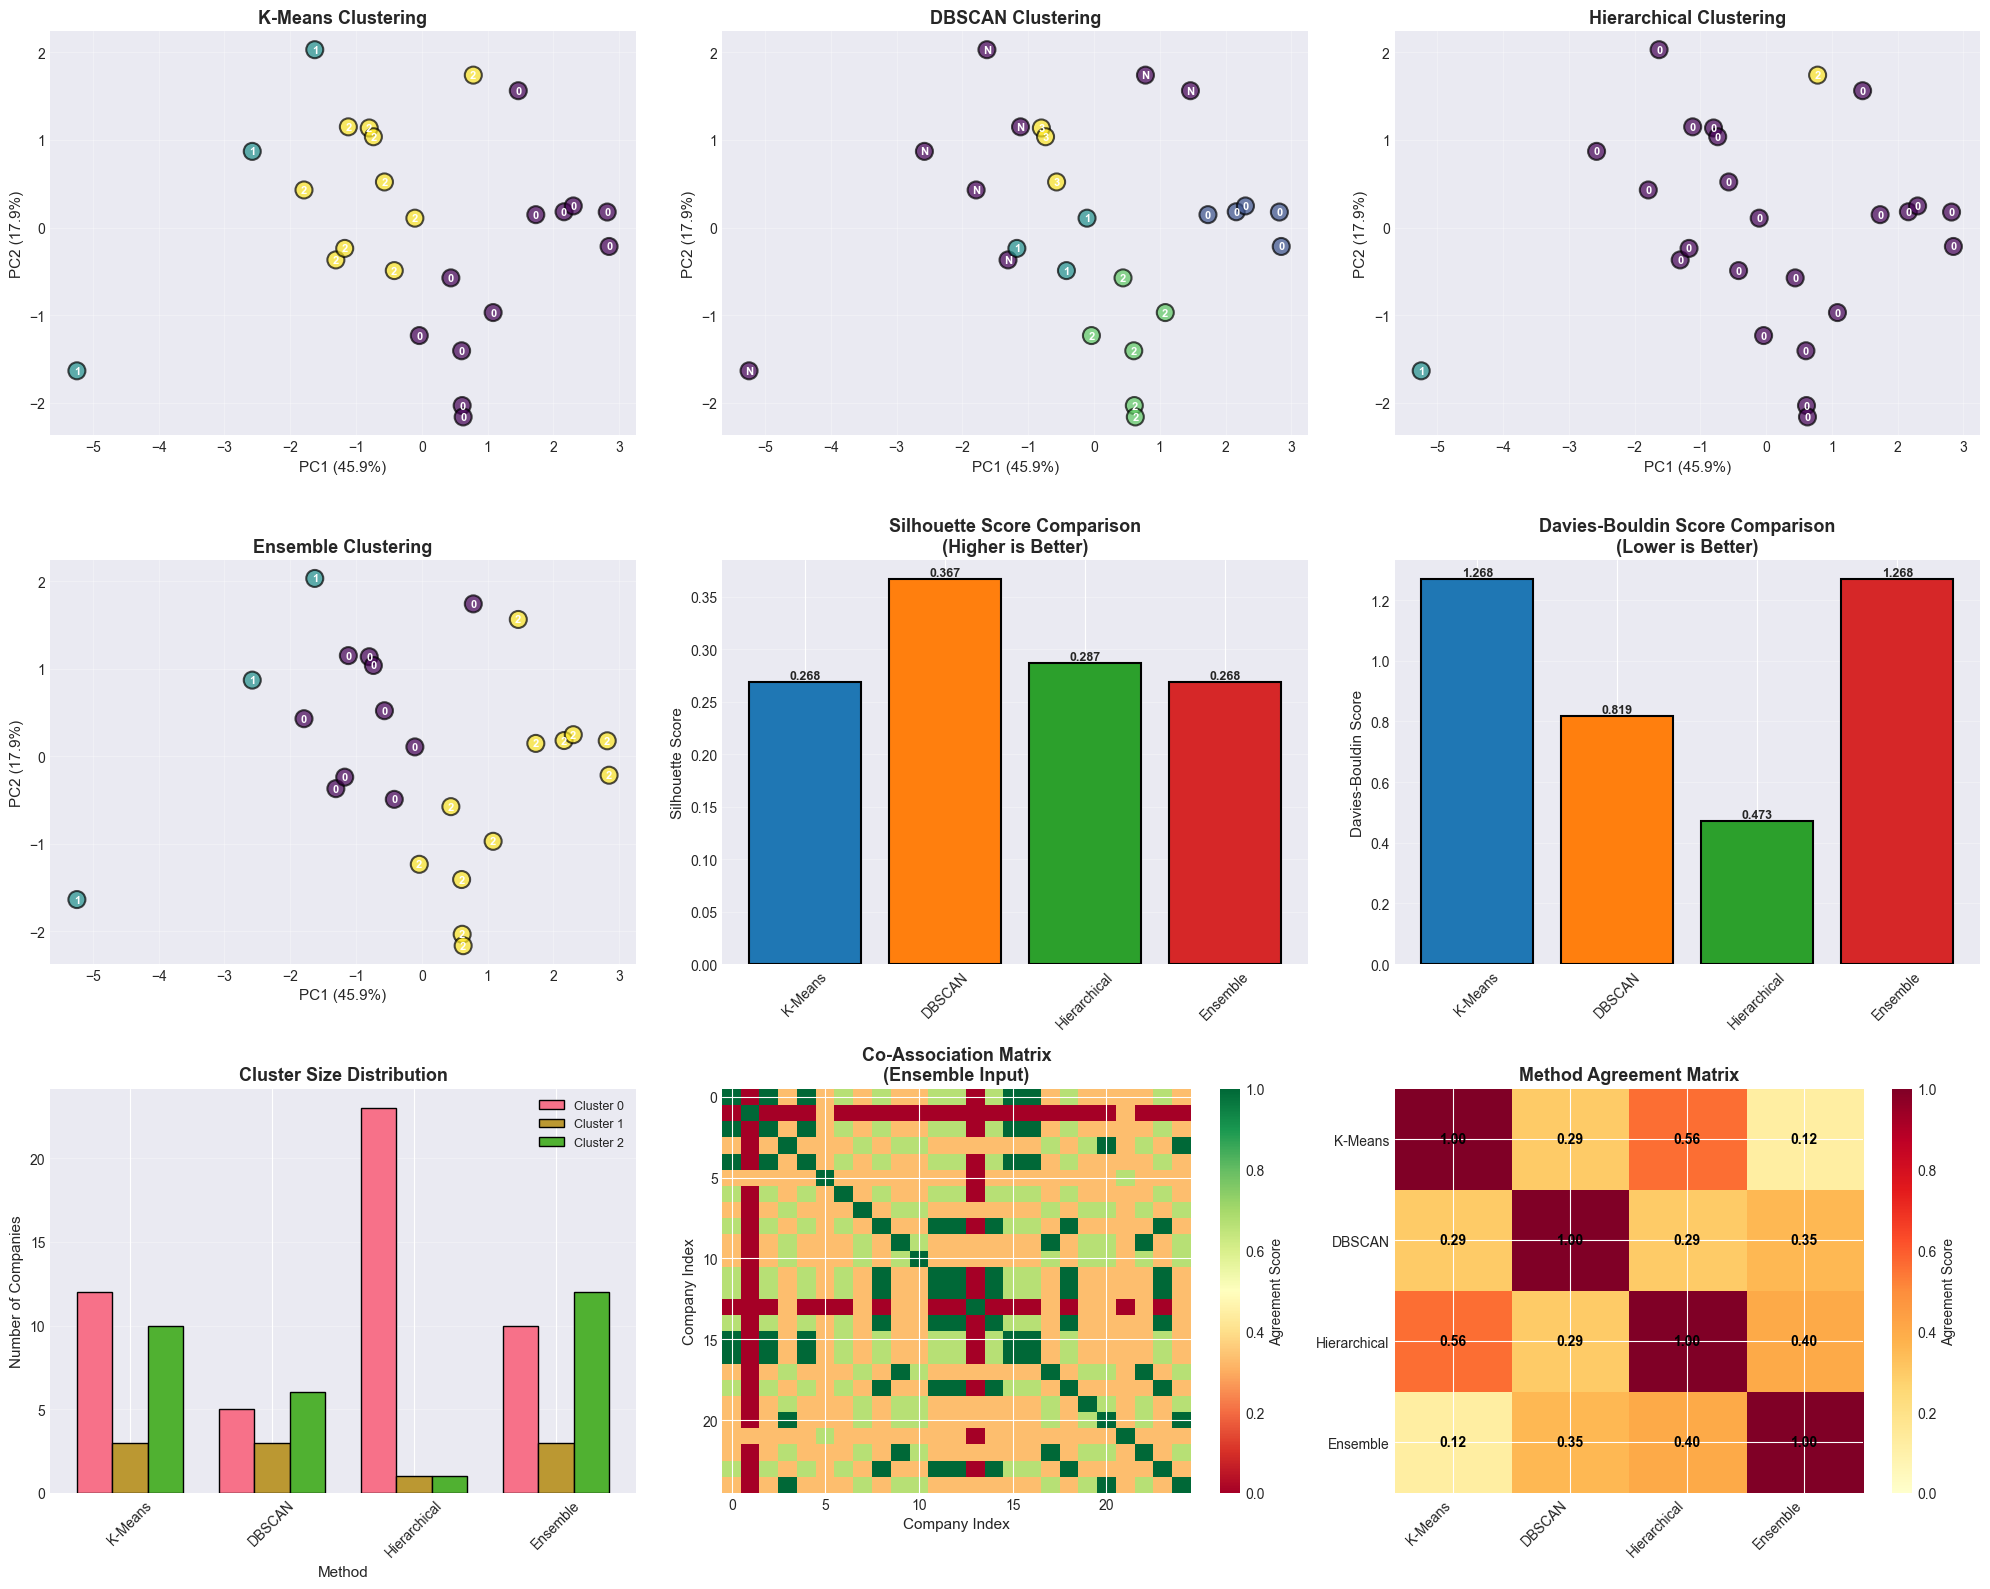

In [11]:
# Visualize All Methods
def visualize_all_methods(X, kmeans_l, dbscan_l, hierarchical_l, ensemble_l, comparison_df):
    """
    Create comprehensive visualization of all clustering methods.
    """
    print("\nGenerating comprehensive visualizations...")
    
    fig = plt.figure(figsize=(20, 16))
    
    # PCA for 2D visualization
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = pca.fit_transform(X)
    
    methods = [
        ('K-Means', kmeans_l),
        ('DBSCAN', dbscan_l),
        ('Hierarchical', hierarchical_l),
        ('Ensemble', ensemble_l)
    ]
    
    # 1-4: PCA Visualizations for each method
    for idx, (method_name, labels) in enumerate(methods, 1):
        ax = plt.subplot(3, 3, idx)
        
        # Handle noise points for DBSCAN
        scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], 
                           c=labels, cmap='viridis', 
                           s=150, alpha=0.7, edgecolors='black', linewidth=1.5)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
        ax.set_title(f'{method_name} Clustering', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add cluster labels to points
        for i, (x, y) in enumerate(X_2d):
            label = 'N' if labels[i] == -1 else str(labels[i])
            ax.annotate(label, (x, y), fontsize=8, ha='center', va='center', 
                       fontweight='bold', color='white')
    
    # 5: Metrics Comparison - Silhouette
    ax5 = plt.subplot(3, 3, 5)
    bars = ax5.bar(comparison_df['Method'], comparison_df['Silhouette'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                   edgecolor='black', linewidth=1.5)
    ax5.set_ylabel('Silhouette Score', fontsize=11)
    ax5.set_title('Silhouette Score Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 6: Metrics Comparison - Davies-Bouldin
    ax6 = plt.subplot(3, 3, 6)
    bars = ax6.bar(comparison_df['Method'], comparison_df['Davies-Bouldin'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                   edgecolor='black', linewidth=1.5)
    ax6.set_ylabel('Davies-Bouldin Score', fontsize=11)
    ax6.set_title('Davies-Bouldin Score Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 7: Cluster Size Distribution Comparison
    ax7 = plt.subplot(3, 3, 7)
    x_pos = np.arange(len(methods))
    width = 0.25
    
    for cluster_id in range(TARGET_CLUSTERS):
        sizes = []
        for _, labels in methods:
            count = np.sum(labels == cluster_id)
            sizes.append(count)
        
        ax7.bar(x_pos + cluster_id * width, sizes, width, 
               label=f'Cluster {cluster_id}', edgecolor='black', linewidth=1)
    
    ax7.set_xlabel('Method', fontsize=11)
    ax7.set_ylabel('Number of Companies', fontsize=11)
    ax7.set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
    ax7.set_xticks(x_pos + width)
    ax7.set_xticklabels([m[0] for m in methods], rotation=45)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8: Co-Association Matrix
    ax8 = plt.subplot(3, 3, 8)
    im = ax8.imshow(coassoc_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax8.set_title('Co-Association Matrix\n(Ensemble Input)', fontsize=13, fontweight='bold')
    ax8.set_xlabel('Company Index', fontsize=11)
    ax8.set_ylabel('Company Index', fontsize=11)
    plt.colorbar(im, ax=ax8, label='Agreement Score')
    
    # 9: Method Agreement Heatmap
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate agreement between methods
    agreement_matrix = np.zeros((4, 4))
    method_labels_list = [kmeans_l, dbscan_l, hierarchical_l, ensemble_l]
    method_names = ['K-Means', 'DBSCAN', 'Hierarchical', 'Ensemble']
    
    for i in range(4):
        for j in range(4):
            labels_i = method_labels_list[i]
            labels_j = method_labels_list[j]
            
            # Handle noise points
            valid_mask = (labels_i >= 0) & (labels_j >= 0)
            if valid_mask.sum() > 0:
                agreement = np.sum(labels_i[valid_mask] == labels_j[valid_mask]) / valid_mask.sum()
                agreement_matrix[i, j] = agreement
    
    im = ax9.imshow(agreement_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax9.set_xticks(range(4))
    ax9.set_yticks(range(4))
    ax9.set_xticklabels(method_names, rotation=45, ha='right')
    ax9.set_yticklabels(method_names)
    ax9.set_title('Method Agreement Matrix', fontsize=13, fontweight='bold')
    
    # Add text annotations
    for i in range(4):
        for j in range(4):
            text = ax9.text(j, i, f'{agreement_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    plt.colorbar(im, ax=ax9, label='Agreement Score')
    
    plt.tight_layout()
    plt.savefig('../data/results/company_clustering_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved to: ../data/results/company_clustering_comparison.png")
    plt.show()

visualize_all_methods(X_scaled, kmeans_labels, dbscan_labels, 
                     hierarchical_labels, ensemble_labels, comparison_df)

---
## Cluster Profiling & Recommendations

In [12]:
# Analyze and Label Clusters as Low/Mid/High Performance
def profile_clusters(df, labels, method_name, feature_columns):
    """
    Profile clusters and assign Low/Mid/High performance labels.
    """
    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - CLUSTER PROFILING")
    print(f"{'='*70}\n")
    
    df_labeled = df.copy()
    df_labeled['cluster'] = labels
    
    # Calculate overall performance score for each cluster
    cluster_scores = df_labeled.groupby('cluster')['overall_score_mean'].mean().sort_values()
    
    # Assign performance tiers
    performance_map = {}
    valid_clusters = [c for c in cluster_scores.index if c >= 0]  # Exclude noise
    
    if len(valid_clusters) >= 3:
        performance_map[valid_clusters[0]] = 'Low Performance'
        performance_map[valid_clusters[1]] = 'Mid Performance'
        performance_map[valid_clusters[2]] = 'High Performance'
    elif len(valid_clusters) == 2:
        performance_map[valid_clusters[0]] = 'Low Performance'
        performance_map[valid_clusters[1]] = 'High Performance'
    
    if -1 in cluster_scores.index:  # Noise points
        performance_map[-1] = 'Outliers'
    
    df_labeled['performance_tier'] = df_labeled['cluster'].map(performance_map)
    
    # Display cluster profiles
    for cluster_id in sorted([c for c in df_labeled['cluster'].unique() if c >= 0]):
        cluster_data = df_labeled[df_labeled['cluster'] == cluster_id]
        tier = performance_map.get(cluster_id, 'Unknown')
        
        print(f"\nCluster {cluster_id}: {tier}")
        print(f"  Companies: {len(cluster_data)}")
        print(f"  Supplier IDs: {', '.join(cluster_data['supplier_id'].tolist())}")
        print(f"\n  Key Metrics:")
        
        for feature in feature_columns:
            mean_val = cluster_data[feature].mean()
            print(f"    {feature:30s}: {mean_val:6.2f}")
    
    # Handle noise if present
    if -1 in df_labeled['cluster'].values:
        noise_data = df_labeled[df_labeled['cluster'] == -1]
        print(f"\nNoise/Outliers: {len(noise_data)} companies")
        print(f"  Supplier IDs: {', '.join(noise_data['supplier_id'].tolist())}")
    
    return df_labeled, performance_map

# Profile all methods
df_kmeans_profiled, kmeans_perf_map = profile_clusters(df_raw, kmeans_labels, 'K-Means', feature_columns)
df_dbscan_profiled, dbscan_perf_map = profile_clusters(df_raw, dbscan_labels, 'DBSCAN', feature_columns)
df_hierarchical_profiled, hierarchical_perf_map = profile_clusters(df_raw, hierarchical_labels, 'Hierarchical', feature_columns)
df_ensemble_profiled, ensemble_perf_map = profile_clusters(df_raw, ensemble_labels, 'Ensemble', feature_columns)


K-MEANS - CLUSTER PROFILING


Cluster 0: High Performance
  Companies: 12
  Supplier IDs: SUP_001, SUP_003, SUP_005, SUP_007, SUP_009, SUP_012, SUP_013, SUP_015, SUP_016, SUP_017, SUP_019, SUP_024

  Key Metrics:
    delivery_reliability_mean     :  67.66
    cost_efficiency_mean          :  65.24
    defect_rate_mean              :   1.75
    quality_score_mean            :  82.29
    customer_satisfaction_mean    :   7.55
    overall_score_mean            :  74.72
    order_volume_mean             : 210.01

Cluster 1: Low Performance
  Companies: 3
  Supplier IDs: SUP_002, SUP_006, SUP_022

  Key Metrics:
    delivery_reliability_mean     :  67.82
    cost_efficiency_mean          :  54.06
    defect_rate_mean              :   4.82
    quality_score_mean            :  51.22
    customer_satisfaction_mean    :   5.66
    overall_score_mean            :  56.72
    order_volume_mean             : 175.83

Cluster 2: Mid Performance
  Companies: 10
  Supplier IDs: SUP_004, SUP_008, SUP_0

In [13]:
# Generate Recommendations
def generate_recommendations(df_profiled, performance_map, method_name):
    """
    Generate actionable recommendations for each performance tier.
    """
    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - RECOMMENDATIONS")
    print(f"{'='*70}\n")
    
    recommendations = []
    
    tier_strategies = {
        'High Performance': {
            'strategy': 'Maintain Excellence & Strategic Partnership',
            'actions': [
                'Prioritize for critical and high-value projects',
                'Establish long-term strategic partnerships',
                'Leverage as benchmark for other suppliers',
                'Increase order volumes and exclusivity agreements'
            ]
        },
        'Mid Performance': {
            'strategy': 'Continuous Improvement & Development',
            'actions': [
                'Provide targeted training and support',
                'Set incremental performance improvement goals',
                'Regular performance reviews and feedback',
                'Offer incentives for reaching high-performance tier'
            ]
        },
        'Low Performance': {
            'strategy': 'Intensive Support or Alternative Sourcing',
            'actions': [
                'Conduct root cause analysis of performance issues',
                'Implement performance improvement plans',
                'Consider reducing order volumes',
                'Explore alternative suppliers for critical items',
                'Set strict performance milestones with consequences'
            ]
        },
        'Outliers': {
            'strategy': 'Special Attention Required',
            'actions': [
                'Detailed individual assessment needed',
                'May have unique characteristics not captured by main clusters',
                'Evaluate case-by-case for retention or termination'
            ]
        }
    }
    
    for tier, info in tier_strategies.items():
        tier_data = df_profiled[df_profiled['performance_tier'] == tier]
        
        if len(tier_data) > 0:
            print(f"\n{tier.upper()}")
            print(f"  Companies: {len(tier_data)}")
            print(f"  Strategy: {info['strategy']}")
            print(f"  Recommended Actions:")
            for action in info['actions']:
                print(f"    • {action}")
            
            recommendations.append({
                'Performance Tier': tier,
                'Count': len(tier_data),
                'Percentage': f"{len(tier_data)/len(df_profiled)*100:.1f}%",
                'Strategy': info['strategy'],
                'Suppliers': ', '.join(tier_data['supplier_id'].tolist())
            })
    
    return pd.DataFrame(recommendations)

# Generate recommendations for ensemble (primary method)
recommendations_df = generate_recommendations(df_ensemble_profiled, ensemble_perf_map, 'Ensemble')

print(f"\n{'='*70}")
print("Recommendations generated successfully")
print(f"{'='*70}")


ENSEMBLE - RECOMMENDATIONS


HIGH PERFORMANCE
  Companies: 12
  Strategy: Maintain Excellence & Strategic Partnership
  Recommended Actions:
    • Prioritize for critical and high-value projects
    • Establish long-term strategic partnerships
    • Leverage as benchmark for other suppliers
    • Increase order volumes and exclusivity agreements

MID PERFORMANCE
  Companies: 10
  Strategy: Continuous Improvement & Development
  Recommended Actions:
    • Provide targeted training and support
    • Set incremental performance improvement goals
    • Regular performance reviews and feedback
    • Offer incentives for reaching high-performance tier

LOW PERFORMANCE
  Companies: 3
  Strategy: Intensive Support or Alternative Sourcing
  Recommended Actions:
    • Conduct root cause analysis of performance issues
    • Implement performance improvement plans
    • Consider reducing order volumes
    • Explore alternative suppliers for critical items
    • Set strict performance milestones w

---
## Save Results

In [14]:
# Save All Results
def save_all_results(df_kmeans, df_dbscan, df_hierarchical, df_ensemble, 
                     comparison_df, recommendations_df):
    """
    Save all clustering results and analysis.
    """
    print(f"\n{'='*70}")
    print("SAVING RESULTS")
    print(f"{'='*70}\n")
    
    # Save individual method results
    df_kmeans.to_csv('../data/results/company_kmeans_clusters.csv', index=False)
    print("K-Means results saved")
    
    df_dbscan.to_csv('../data/results/company_dbscan_clusters.csv', index=False)
    print("DBSCAN results saved")
    
    df_hierarchical.to_csv('../data/results/company_hierarchical_clusters.csv', index=False)
    print("Hierarchical results saved")
    
    df_ensemble.to_csv('../data/results/company_ensemble_clusters.csv', index=False)
    print("Ensemble results saved")
    
    # Save comparison
    comparison_df.to_csv('../data/results/company_clustering_comparison.csv', index=False)
    print("Method comparison saved")
    
    # Save recommendations
    recommendations_df.to_csv('../data/results/company_clustering_recommendations.csv', index=False)
    print("Recommendations saved")
    
    # Generate comprehensive report
    report_path = '../data/results/company_clustering_report.txt'
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("COMPANY CLUSTERING ANALYSIS - COMPREHENSIVE REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write("OBJECTIVE\n")
        f.write("-" * 40 + "\n")
        f.write("Classify 25 companies into 3 performance tiers:\n")
        f.write("  • High Performance (Top tier)\n")
        f.write("  • Mid Performance (Balanced)\n")
        f.write("  • Low Performance (Needs improvement)\n\n")
        
        f.write("METHODOLOGY\n")
        f.write("-" * 40 + "\n")
        f.write("Four clustering approaches applied:\n")
        f.write("  1. K-Means Clustering\n")
        f.write("  2. DBSCAN (Density-based)\n")
        f.write("  3. Hierarchical Clustering\n")
        f.write("  4. Ensemble (Consensus of all three)\n\n")
        
        f.write("FEATURES USED\n")
        f.write("-" * 40 + "\n")
        for i, feature in enumerate(feature_columns, 1):
            f.write(f"  {i}. {feature}\n")
        f.write("\n")
        
        f.write("PERFORMANCE COMPARISON\n")
        f.write("-" * 40 + "\n")
        f.write(comparison_df.to_string(index=False))
        f.write("\n\n")
        
        f.write("RECOMMENDED CLASSIFICATION (Ensemble Method)\n")
        f.write("-" * 40 + "\n")
        f.write(recommendations_df.to_string(index=False))
        f.write("\n\n")
    
    print(f"Comprehensive report saved to: {report_path}")
    

save_all_results(df_kmeans, df_dbscan, df_hierarchical, df_ensemble_profiled,
                comparison_df, recommendations_df)


SAVING RESULTS

K-Means results saved
DBSCAN results saved
Hierarchical results saved
Ensemble results saved
Method comparison saved
Recommendations saved
Comprehensive report saved to: ../data/results/company_clustering_report.txt
